In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import re
import os

from torchbeast.monobeast import create_env, AtariNet
from torchbeast.resnet_monobeast import ResNet
from torchbeast.core import environment

In [58]:
model_base_path = "../models"
models = [
    ("Carnival", ["CarnivalNoFrameskip-v4"]),
    ("AirRaid", ["AirRaidNoFrameskip-v4"]),
    ("DemonAttack", ["DemonAttackNoFrameskip-v4"]),
    ("NameThisGame", ["NameThisGameNoFrameskip-v4"]),
    ("Pong", ["PongNoFrameskip-v4"]),
    ("SpaceInvaders", ["SpaceInvadersNoFrameskip-v4"]),
    ("MultiTask", [
        "CarnivalNoFrameskip-v4", 
        "AirRaidNoFrameskip-v4", 
        "DemonAttackNoFrameskip-v4", 
        "NameThisGameNoFrameskip-v4", 
        "PongNoFrameskip-v4", 
        "SpaceInvadersNoFrameskip-v4"
    ])
]
n_iterations = 10000
ACTION_MEANING = {
    0: "NOOP",
    1: "FIRE",
    2: "UP",
    3: "RIGHT",
    4: "LEFT",
    5: "DOWN",
    6: "UPRIGHT",
    7: "UPLEFT",
    8: "DOWNRIGHT",
    9: "DOWNLEFT",
    10: "UPFIRE",
    11: "RIGHTFIRE",
    12: "LEFTFIRE",
    13: "DOWNFIRE",
    14: "UPRIGHTFIRE",
    15: "UPLEFTFIRE",
    16: "DOWNRIGHTFIRE",
    17: "DOWNLEFTFIRE",
}

In [59]:
data = []
for model_directory, environments in models:
    checkpoints = []
    for checkpoint in os.listdir(os.path.join(model_base_path, model_directory, "intermediate")):
        if not checkpoint.endswith(".tar"):
            continue
        checkpoint_n = int(re.search(r'\d+', checkpoint).group())
        checkpoints.append((checkpoint_n, checkpoint))
    checkpoints.sort()
    
    n_checkpoints = len(checkpoints)
    selected_models = [
        checkpoints[0],
        checkpoints[n_checkpoints // 3],
        checkpoints[n_checkpoints // 3 * 2],
        checkpoints[-1]
    ]
    
    for env_name in environments:
        env_actions = []
        for iteration_count, checkpoint_file in selected_models:
            checkpoint = torch.load(os.path.join(model_base_path, model_directory, "intermediate", checkpoint_file), map_location="cpu")
            if "baseline.mu" not in checkpoint["model_state_dict"]:
                checkpoint["model_state_dict"]["baseline.mu"] = torch.zeros(1)
                checkpoint["model_state_dict"]["baseline.sigma"] = torch.ones(1)
                num_tasks = 1
            else:
                num_tasks = checkpoint["model_state_dict"]["baseline.mu"].shape[0]
            num_actions = checkpoint["model_state_dict"]["policy.weight"].shape[0]

            model = ResNet(observation_shape=None,
                                num_actions=num_actions,
                                num_tasks=num_tasks,
                                use_lstm=False,
                                use_popart=True,
                                reward_clipping="abs_one")
            model.eval()
            model.load_state_dict(checkpoint["model_state_dict"])
            
            gym_env = create_env(env_name)
            gym_env.seed(42)
            env = environment.Environment(gym_env)
            
            observation = env.initial()
            actions = []
            with torch.no_grad():
                for i in range(n_iterations):
                    agent_outputs, state = model(observation)
                    action = agent_outputs["action"]
                    actions.append(action.item())
                    observation = env.step(action)
            
            actions = np.array(actions)
            counts = []
            possible_actions = list(range(gym_env.action_space.n))
            for i in possible_actions:
                counts.append((actions == i).sum())
            
            env_actions.append((iteration_count, [c / n_iterations * 100 for c in counts]))
        data.append((model_directory, env_name, env_actions))

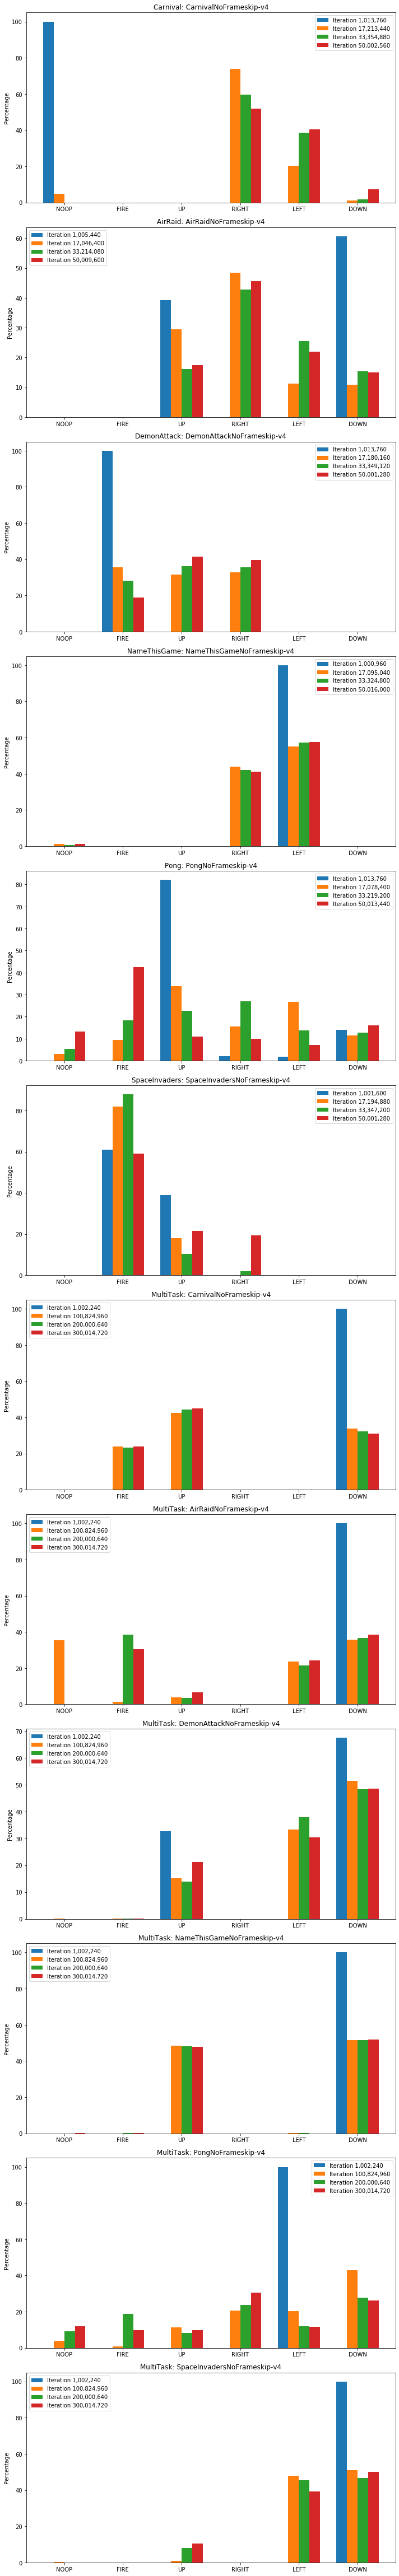

In [67]:
fig, axs = plt.subplots(len(data), figsize=(10, 64))
for i, (model_name, env_name, env_actions) in enumerate(data):
    width = 0.18
    x = np.arange(6)
    rects = []
    for j, (iterations, counts) in enumerate(env_actions):
        rect = axs[i].bar(x - 3 * width / 2 + j * width, counts, width, label=f'Iteration {iterations:,}')
        rects.append(rect)
    
    axs[i].set_xticks(x)
    axs[i].set_xticklabels([ACTION_MEANING[k] for k in range(6)])
    axs[i].set_ylabel('Percentage')
    axs[i].set_title(f'{model_name}: {env_name}')
    axs[i].legend()

fig.tight_layout()
plt.savefig("action_distributions.png")